In [2]:
from sklearn.model_selection import train_test_split
import os
import shutil

def split_data(main_folder, train_folder, test_folder, test_size=0.2):
    # Create train and test directories if they don't exist
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Get the list of all subdirectories in the main folder
    subdirectories = [f.path for f in os.scandir(main_folder) if f.is_dir()]

    for subdirectory in subdirectories:
        class_name = os.path.basename(subdirectory)
        train_class_folder = os.path.join(train_folder, class_name)
        test_class_folder = os.path.join(test_folder, class_name)

        # Create train and test class directories if they don't exist
        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        # Get the list of files in the class folder
        files = os.listdir(subdirectory)

        # Split the files into train and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Move the files to the train folder
        for file in train_files:
            shutil.copy(os.path.join(subdirectory, file), train_class_folder)

        # Move the files to the test folder
        for file in test_files:
            shutil.copy(os.path.join(subdirectory, file), test_class_folder)

# Specify the paths for your main, train, and test folders
main_folder = '/kaggle/input/skin-dataset-last-version/data_10_classes_last_version'
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

 
split_data(main_folder, train_folder, test_folder, test_size=0.2)

**Preprocessing**

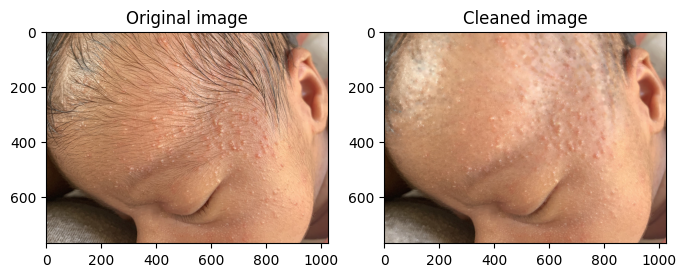

In [3]:
import cv2
import matplotlib.pyplot as plt

# IMAGE ACQUISITION
path = '/kaggle/input/test2-556/dark-skin-baby-acne_4x3.jpg'
image = cv2.imread(path, cv2.IMREAD_COLOR)

def preprocessing(path)
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(image, mask, 6, cv2.INPAINT_TELEA)

    # Convert images to RGB
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cleaned_image = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    return cleaned_image
   # Display images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1), plt.imshow(original_image), plt.title('Original image')
plt.subplot(1, 2, 2), plt.imshow(cleaned_image), plt.title('Cleaned image')
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',  # Directory of training data
    target_size=(224, 224),  # Resize all images to 150x150
    batch_size=32,  # Batch size for training
    class_mode='binary'  # Type of label arrays to return: "binary" for binary classification
)

mobileNet model

In [4]:
from keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
import numpy as np

def load_data(train_path, test_path, img_size=(224, 224), validation_split=0.2):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

def create_model(input_shape=(224, 224, 3), num_classes=10):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)  # Additional dense layer
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

def compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    # Printing training, validation, and testing accuracies
    train_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Training Accuracy:", np.mean(train_accuracy)*100)
    print("Validation Accuracy:", np.mean(validation_accuracy)*100)
    print("Testing Accuracy:", test_accuracy*100)

    return history
#import tensorflow as tf
#model = tf.keras.models.load_model('/kaggle/working/model') # Load your model first
#tf.saved_model.save(model, '/kaggle/working/saved_model')

model_path='/kaggle/working/model23.h5'
save_model_path = os.path.join(model_path, 'model_mob.h5')

def save_model(model,save_model_path ):
    model.save(save_model_path)
def load_model( save_model_path):
    model = load_model(model_path)
    return model

# Main function to run the model
def run_model(train_path, test_path, learning_rate=0.001, epochs=10, save_model_path=None):
    train_generator, validation_generator, test_generator = load_data(train_path, test_path)
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes=num_classes)
    history = compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs)

   
    if save_model_path:
        save_model(model, save_model_path)

    return history

# Example usage for training
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'
save_model_path_MobileNet =  save_model_path
history = run_model(train_path, test_path, learning_rate=0.0001, epochs=6,save_model_path=save_model_path)



2024-06-29 03:34:00.100819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 03:34:00.100958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 03:34:00.262103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 16488 images belonging to 10 classes.
Found 4115 images belonging to 10 classes.
Found 5154 images belonging to 10 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/516 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.1858 - loss: 2.2448   

I0000 00:00:1719632065.147018     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719632065.171097     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


306/516 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.6364 - loss: 1.0608

W0000 00:00:1719632087.281052     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


515/516 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6859 - loss: 0.9202

W0000 00:00:1719632102.282292     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 61s 99ms/step - accuracy: 0.6862 - loss: 0.9192 - val_accuracy: 0.6858 - val_loss: 0.9316
Epoch 2/6


W0000 00:00:1719632116.160645     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.8692 - loss: 0.4009 - val_accuracy: 0.6953 - val_loss: 0.9873
Epoch 3/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.8935 - loss: 0.3273 - val_accuracy: 0.7142 - val_loss: 0.9295
Epoch 4/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9275 - loss: 0.2445 - val_accuracy: 0.7290 - val_loss: 0.9076
Epoch 5/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.9382 - loss: 0.2149 - val_accuracy: 0.7261 - val_loss: 0.9774
Epoch 6/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9526 - loss: 0.1822 - val_accuracy: 0.7463 - val_loss: 0.9256
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8788 - loss: 0.3929
Training Accuracy: 89.35185174147287
Validation Accuracy: 71.61198854446411
Testing Accuracy: 88.18393349647522


W0000 00:00:1719632333.153445     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [5]:
from keras.models import load_model as keras_load_model

def load_model(save_model_path):
    model = keras_load_model(save_model_path)
    return model



In [6]:
treatments =[["Acretin","Panthophil","Fucidin"]
             ,["Go to Doctor to upplay freezing by liquid Nitrogen"],
 ["Eucerin","Aveeno","Cetaphil","Dermalex","Honest","Grahams"]
             ,["Zovirax","Acyclovir","Cutacort"]
             ,["Terrasil","Mupiracin","Mupirax"],
  ["Conzerol","Zymaderm","Cooling or scraping (under the supervision of a doctor)"],
   ["Mostraizers","Betaderm","Betnovate"],
  ["Dermalex","Lapsorin","E45"],
   ["URLAGE","Aveeno","A-DERMA","Skinoren"],
    ["Roycederm","Terrasil","Betaclotry","Dermatin","Dr.Derm(TINEA)"],
      ]


Xception model

In [7]:
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the preprocess_image function
def preprocesss_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Modified load_data function with preprocess_image integration
def load_data(train_path, test_path, img_size=(224, 224), validation_split=0.2):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split, horizontal_flip=True, rotation_range=20)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

# Function to create the Xception model
def create_model(input_shape=(224, 224, 3), num_classes=10):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
    x = Dropout(0.5)(x)  # Added dropout layer
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = True

    return model

# Function to compile and train the model
def compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

    # Printing training, validation, and testing accuracies
    train_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Training Accuracy:", np.mean(train_accuracy)*100)
    print("Validation Accuracy:", np.mean(validation_accuracy)*100)
    print("Testing Accuracy:", test_accuracy*100)

    return history

# Function to save the model
def save_model(model, save_model_path):
    model.save(save_model_path)

# Function to load a saved model
def load_saved_model(save_model_path):
    model = load_model(save_model_path)
    return model

# Main function to run the model
def run_model(train_path, test_path, learning_rate=0.001, epochs=10, save_model_path=None):
    train_generator, validation_generator, test_generator = load_data(train_path, test_path)
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes=num_classes)
    history = compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs)

    if save_model_path:
        save_model(model, save_model_path)

    return history

# Example usage for training
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'
save_model_path_Xception = '/kaggle/working/model_Xception.h5'
history = run_model(train_path, test_path, learning_rate=0.0001, epochs=7, save_model_path=save_model_path_Xception)


Found 16488 images belonging to 10 classes.
Found 4115 images belonging to 10 classes.
Found 5154 images belonging to 10 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/7


W0000 00:00:1719632421.324863     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


374/516 ━━━━━━━━━━━━━━━━━━━━ 1:19 557ms/step - accuracy: 0.6760 - loss: 7.5601

W0000 00:00:1719632629.342738     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7114 - loss: 6.9660

W0000 00:00:1719632702.047767     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 422s 654ms/step - accuracy: 0.7116 - loss: 6.9622 - val_accuracy: 0.7735 - val_loss: 2.8038 - learning_rate: 1.0000e-04
Epoch 2/7


W0000 00:00:1719632758.705156     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 293s 562ms/step - accuracy: 0.9174 - loss: 1.6936 - val_accuracy: 0.8053 - val_loss: 1.2616 - learning_rate: 1.0000e-04
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 294s 564ms/step - accuracy: 0.9480 - loss: 0.5430 - val_accuracy: 0.7978 - val_loss: 0.9611 - learning_rate: 1.0000e-04
Epoch 4/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 293s 563ms/step - accuracy: 0.9712 - loss: 0.2256 - val_accuracy: 0.8029 - val_loss: 0.9584 - learning_rate: 1.0000e-04
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 293s 563ms/step - accuracy: 0.9784 - loss: 0.1350 - val_accuracy: 0.8051 - val_loss: 1.0023 - learning_rate: 1.0000e-04
Epoch 6/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 293s 563ms/step - accuracy: 0.9825 - loss: 0.1019 - val_accuracy: 0.7844 - val_loss: 0.9519 - learning_rate: 1.0000e-04
Epoch 7/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 294s 564ms/step - accuracy: 0.9875 - loss: 0.0829 - val_accuracy: 0.7747 - val_loss: 1.1360 - learning_rate: 1.0000e-04
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 

W0000 00:00:1719634543.502701     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Accuracy: 94.51549223491124
Validation Accuracy: 79.19805645942688
Testing Accuracy: 92.74349808692932


InceptionV3


In [8]:
import os
from keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
import numpy as np

def load_data(train_path, test_path, img_size=(224, 224), validation_split=0.2):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split, horizontal_flip=True, rotation_range=20, zoom_range=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

from keras.callbacks import EarlyStopping
from keras.regularizers import l2

def create_model(input_shape=(224, 224, 3), num_classes=10):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.05))(x)  # Increased L2 regularization
    x = Dropout(0.5)(x)  # Added dropout with a higher rate
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

def compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)  # Reduced patience for early stopping

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator,
                       callbacks=[early_stopping])

    # Printing training, validation, and testing accuracies
    train_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Training Accuracy:", np.mean(train_accuracy)*100)
    print("Validation Accuracy:", np.mean(validation_accuracy)*100)
    print("Testing Accuracy:", test_accuracy*100)

    return history

model_path = '/kaggle/working/model3.h5'
save_model_path = os.path.join(model_path, 'model_inception.h5')

def save_model(model, save_model_path):
    model.save(save_model_path)

def load_saved_model(save_model_path):
    model = load_model(save_model_path)
    return model

# Main function to run the model
def run_model(train_path, test_path, learning_rate=0.00001, epochs=20, save_model_path=None):
    train_generator, validation_generator, test_generator = load_data(train_path, test_path)
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes=num_classes)
    history = compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs)

    if save_model_path:
        save_model(model, save_model_path)

    return history

# Example usage for training
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'
save_model_path_Inception = '/kaggle/working/model_inception.h5'
history = run_model(train_path, test_path, learning_rate=0.00001, epochs=6, save_model_path=save_model_path)

Found 16488 images belonging to 10 classes.
Found 4115 images belonging to 10 classes.
Found 5154 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6
  2/516 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - accuracy: 0.1250 - loss: 43.8292   

W0000 00:00:1719634575.298224     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/516 ━━━━━━━━━━━━━━━━━━━━ 3:12 454ms/step - accuracy: 0.1839 - loss: 43.0913

W0000 00:00:1719634616.019036     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.3219 - loss: 41.2847

W0000 00:00:1719634765.431467     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 275s 482ms/step - accuracy: 0.3221 - loss: 41.2810 - val_accuracy: 0.5295 - val_loss: 35.8232
Epoch 2/6


W0000 00:00:1719634823.524970     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 229s 439ms/step - accuracy: 0.5690 - loss: 34.2538 - val_accuracy: 0.5529 - val_loss: 29.8957
Epoch 3/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 227s 436ms/step - accuracy: 0.6282 - loss: 28.4806 - val_accuracy: 0.5920 - val_loss: 24.8465
Epoch 4/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 428ms/step - accuracy: 0.6644 - loss: 23.6064 - val_accuracy: 0.5806 - val_loss: 20.6302
Epoch 5/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 429ms/step - accuracy: 0.6714 - loss: 19.5393 - val_accuracy: 0.5915 - val_loss: 17.1378
Epoch 6/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 222s 426ms/step - accuracy: 0.6901 - loss: 16.1778 - val_accuracy: 0.6073 - val_loss: 14.2698
162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.7323 - loss: 13.9953


W0000 00:00:1719635968.156784     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Accuracy: 61.45984878142675
Validation Accuracy: 57.56176710128784
Testing Accuracy: 73.26348423957825


In [10]:
loaded_model1 = load_model("/kaggle/working/model23.h5/model_mob.h5")
loaded_model3 = load_model( "/kaggle/working/model3.h5/model_inception.h5")
loaded_model_2 = load_model( "/kaggle/working/model_Xception.h5")

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def test_model(model, test_image_path, class_labels):
    img = image.load_img(test_image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    # Display the image
    plt.figure(figsize=(3, 2))  # Adjust the size as desired
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    treat=[]
    if  predicted_class=="Acne":
              treat=treatments [0]
    elif  predicted_class=="actinic keratosis":
      treat=treatments [1]
    elif  predicted_class=="Eczemaa":
      treat=treatments [2]
    elif  predicted_class=="Herpes Simplex":
      treat=treatments [3]
    elif  predicted_class=="Impetigo":
      treat=treatments [4]
    elif  predicted_class=="Molluscum Contagiosum":
      treat=treatments [5]
    elif  predicted_class=="Pityriasis Rosea":
      treat=treatments [6]
    elif  predicted_class=="Psoriasis":
      treat=treatments [7]
    elif  predicted_class=="Rosacea":
      treat=treatments [8]
    elif  predicted_class=="Tinea Corporis":
      treat=treatments [9]
    treats = '\n'.join(treat)
    print("Treatments :" )
    print(treats)
    print()
    print("Predicted Class:", predicted_class)
    print("Actual Class:", test_image_path.split("/")[-2])
    print("Confidence:", confidence)
    return confidence , predicted_class
 # Define the class labels
class_labels = ['Acne',
 'Eczemaa',
 'Herpes Simplex',
 'Impetigo',
 'Molluscum Contagiosum',
 'Pityriasis Rosea',
 'Psoriasis',
 'Rosacea',
 'Tinea Corporis',
 'actinic keratosis']
 
# Example usage for testing
#test_image_path = '/kaggle/working/test/Impetigo/2799.jpg'
test_image_path="/kaggle/input/skin-dataset-last-version/data_10_classes_last_version/Herpes Simplex/10227.jpg"
t1,p1=test_model(loaded_model1, test_image_path, class_labels)
t2,p2=test_model(loaded_model3, test_image_path, class_labels)
t3,p3=test_model(loaded_model_2, test_image_path, class_labels)
total_acc=((t1+t3+t2)/3)*100
if(total_acc>50 and(  p1==p2 or p2==p3 or p3==p1  )):
    
    print ("Final Confidence:",total_acc,"%100")
else:
    print("To preserve your health,")
    print("please go to a dermatologist to obtain")
    print("an accurate diagnosis of your disease ,")
    print("as the disease is not clear from the picture only")